<a href="https://colab.research.google.com/github/norightt/python-deep-learning/blob/main/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-30 09:49:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [          <=>       ] 201.24M  11.5MB/s    in 19s     

2024-10-30 09:50:00 (10.8 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
# если что, я так пишу заметки, надеюсь, вы не против

# Fit scaler to the training data -> transform test --> creates an array so we need to set it back to pd.dataframe --> prevents data leakadge, non-normality of  distribution and improves regression results
set_random_seed(42)

scaler.fit(X_train)

x_train_sc = scaler.transform(X_train)
x_train = pd.DataFrame(x_train_sc)

x_test_sc = scaler.transform(X_test)
x_test = pd.DataFrame(x_test_sc)


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

set_random_seed(42)

model = Ridge(0.5).fit(x_train, y_train)

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
y_pred = np.mean(y_train)
best_rmse_metric = root_mean_squared_error(y_test, np.full_like(y_test, y_pred))
best_rmse_metric

10.863228020678134

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
# берем срез сто тыщ
x_train_slice = x_train.iloc[:100000]
y_train_slice = y_train[:100000]
x_test_slice = x_test.iloc[:100000]
y_test_slice = y_test[:100000]

In [ ]:
# преобразовываем некоторые pandas dataframe в numpy arrays с помощью .to_numpy(), а потом все в тензоры
# я знаю, что это уже прописано сверху, но еще раз в ручную проверяем местоположение тензоров и доступность cuda и переносим их на гпу, потому что я тревожная

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

x_train_tensor = (torch.tensor(x_train_slice.to_numpy(), dtype=torch.float).to(device))
y_train_tensor = torch.tensor(y_train_slice, dtype=torch.float).to(device)
x_test_tensor = (torch.tensor(x_test_slice.to_numpy(), dtype=torch.float).to(device))
y_test_tensor = torch.tensor(y_test_slice, dtype=torch.float).to(device)

x_train_tensor.is_cuda

True

In [ ]:
x_train_tensor.shape

torch.Size([100000, 90])

In [ ]:
# в семинаре 1 про dataloader и батчи
from torch.utils.data import Dataset, DataLoader
class LinearDataset(Dataset):
    def __init__(self, x_data, y_data):    # поля класса
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):    # сколько объектов в датасете
        return len(self.x_data)

    def __getitem__(self, idx):   # сэмпл + таргет по индексу
        return self.x_data[idx], self.y_data[idx]

In [ ]:
# Экземпляры Dataset

train_dataset = LinearDataset(x_train_tensor, y_train_tensor)
test_dataset = LinearDataset(x_test_tensor, y_test_tensor)

# Сам DataLoader
# на трейне - shuffle, на тесте - нет: для лучшего обобщения

dataloader_train = DataLoader(train_dataset, batch_size = 10, shuffle = True)
dataloader_test = DataLoader(test_dataset, batch_size = 10, shuffle = False)

In [ ]:
# в семинаре 1 про наследование модуля nn.Module и метода forward в high-level PyTorch
# модуль nn.Linear https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

class LinearRegression(nn.Module):
  def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(90, 1)       # n_features = 90, out_features = 1 -- один слой

  def forward(self, x):
        return self.linear(x)               # применяет линейную транформацию к входному тензору y = xA^T + b


In [ ]:
!pip install wandb --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 81.3 MB/s eta 0:00:00


In [ ]:
import wandb
!wandb login

wandb: Currently logged in as: maria-21 (maria-21-hse). Use `wandb login --relogin` to force relogin


In [ ]:
set_random_seed(42)

modelka = LinearRegression()
modelka.to(device)

wandb.init(project="hw1")
wandb.watch(modelka);

mean test accuracy,▁▁▁▁▁▁▁▁
mean test loss,▇▄▁▄█▅▄▅
mean train loss,█▄▃▂▂▁▁▁
mean test accuracy,0
mean test loss,8.56834
mean train loss,116.90555


In [ ]:
losses_train = []
losses_test = []

for epoch in range(10):
  for x_train, y_train in tqdm(dataloader_train):
    y_pred = modelka(x_train.to(device))
    loss = torch.sqrt(torch.mean((y_pred - y_train.to(device))**2))

    modelka.zero_grad() # обнуляем градиенты
    loss.backward() # метод обратного распространения ошибки

    losses_train.append(loss.detach().cpu().numpy())

    with torch.no_grad(): # апдейт параметров модели вручную
      for param in modelka.parameters():
        param -= 0.05 * param.grad

  with torch.no_grad():
    for x_test, y_test in tqdm(dataloader_test):
      y_pred_test = modelka(x_test.to(device))
      test_loss = torch.sqrt(torch.mean((y_pred_test - y_test.to(device))**2))
      losses_test.append(test_loss.cpu().numpy())


  wandb.log(
             {
                 "mean train loss": np.mean(losses_train),
                 "mean test loss": np.mean(losses_test),
             })

  print(
            f"Epoch: {epoch}, loss train: {np.mean(losses_train)}, loss test: {np.mean(losses_test)}"
        )

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 0, loss train: 422.43450927734375, loss test: 176.02047729492188


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 1, loss train: 230.5382537841797, loss test: 92.34591674804688


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 2, loss train: 157.1145782470703, loss test: 64.44766998291016


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 3, loss train: 120.40190887451172, loss test: 50.485801696777344


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 4, loss train: 98.37297821044922, loss test: 42.11737060546875


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 5, loss train: 83.68875122070312, loss test: 36.53483200073242


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 6, loss train: 73.20063018798828, loss test: 32.549354553222656


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 7, loss train: 65.3333511352539, loss test: 29.554798126220703


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 8, loss train: 59.2139778137207, loss test: 27.228837966918945


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 9, loss train: 54.31899642944336, loss test: 25.37287712097168


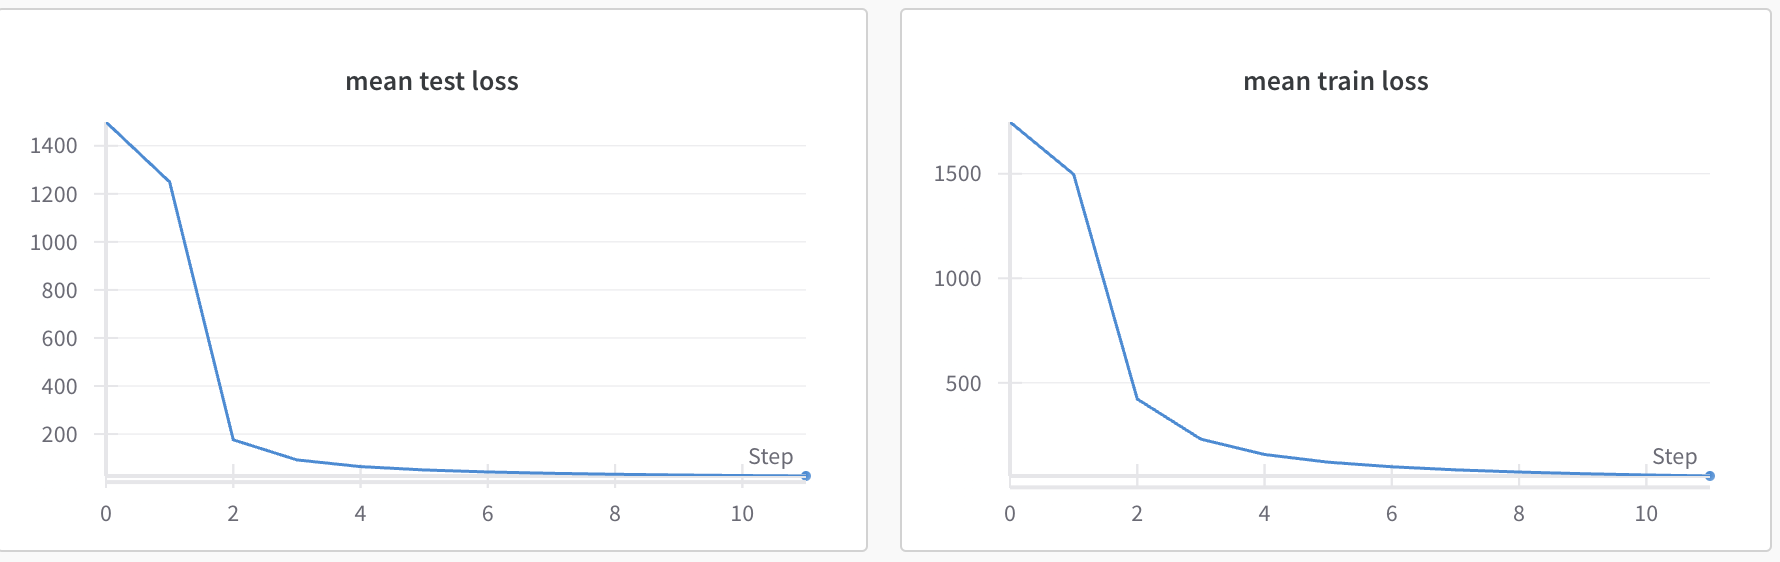

Вот такие штучки получились в wandb...красивое

https://api.wandb.ai/links/maria-21-hse/85m181tk -- mean test loss

https://api.wandb.ai/links/maria-21-hse/6q80mlhr -- mean train loss

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

**Exploratory Data Analysis** 😙💋

Посмотрим, как распределенна целевая переменная: получилось негативное нессиметричное распределение как на трейне, так и на тесте --> большинство песен вышло после 2000 года.

Text(0, 0.5, 'Frequency')

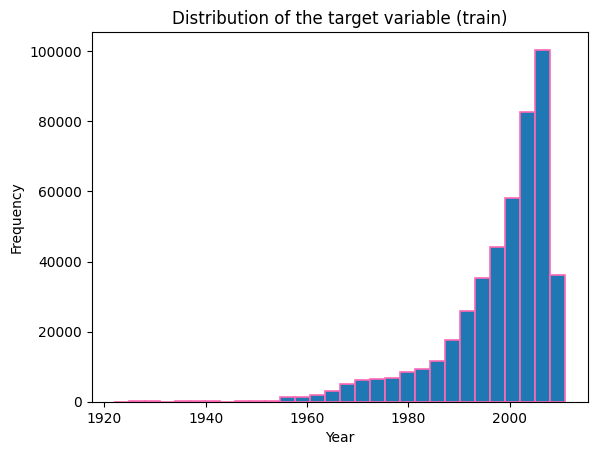

In [ ]:
plt.hist(y_train, bins= 30, edgecolor = 'hotpink', linewidth = 1.2)
plt.title("Distribution of the target variable (train)")
plt.xlabel("Year")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

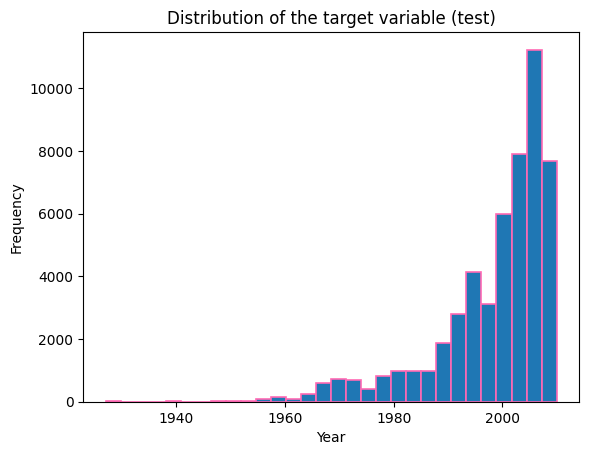

In [ ]:
plt.hist(y_test, bins= 30, edgecolor = 'hotpink', linewidth = 1.2)
plt.title("Distribution of the target variable (test)")
plt.xlabel("Year")
plt.ylabel("Frequency")

На корреляционной матрице видно...не много

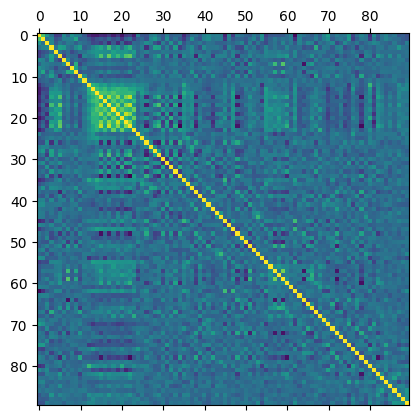

In [ ]:
plt.matshow(x_train.corr())
plt.show()

Отмасштабируем таргет, потом сделаем новый датасет и даталоадер с помощью вышеобозначенного класса, так как в прошлом задании я брала только срез данных, в этот раз будем фигачить сразу все 🔥

In [ ]:
x_train_tensor = (torch.tensor(x_train.to_numpy(), dtype=torch.float).to(device))
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)
x_test_tensor = (torch.tensor(x_test.to_numpy(), dtype=torch.float).to(device))
y_test_tensor = torch.tensor(y_test, dtype=torch.float).to(device)

In [ ]:
# коллеги подсказали как по-человечески реализовать нормализацию тензора таргета (https://www.geeksforgeeks.org/how-to-normalize-a-tensor-to-0-mean-and-1-variance-in-pytorch/)
# t  = (t-mean)/std
std = torch.std(y_train_tensor)
mean = torch.mean(y_train_tensor)
y_train_tensor = (y_train_tensor - mean) / std
y_test_tensor = (y_test_tensor - mean) / std

In [ ]:
# если берем все данные, наверно, имеет смысл брать batch size побольше
train_set = LinearDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_set, batch_size = 128, shuffle = True)

test_set = LinearDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_set, batch_size = 128, shuffle = False)


class LinReg2(nn.Module):
  def __init__(self):
        super(LinReg2, self).__init__()
        self.linear = nn.Linear(90, 1)
        self.relu = nn.ReLU() # https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
        self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = self.relu(self.linear(x))
    x = self.dropout(x)
    return x



In [ ]:
set_random_seed(42)
model = LinReg2()
model.to(device)


optimizer = torch.optim.SGD(model.parameters(), lr=0.001) # momentum = 0.8
criterion = nn.MSELoss()
n_epochs = 10

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader, n_epochs):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        n_epochs - number of epochs (добавила чтобы менять кол-во эпох)
    """
    # очень много инсайтов взято из этой статьи про дропаут https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models/

    wandb.init(project="hw1.2")
    wandb.watch(model);



    model.train() # ставить модель в разные modes типа .train(), .eval() нужно для дропаута (и не только)

    for epoch in range(n_epochs):
      total_loss = 0
      for x_batch, y_batch in tqdm(train_loader):
          y_pred = model(x_batch.to(device))
          loss = torch.sqrt(criterion(y_pred,y_batch.view(-1,1).to(device))) #https://discuss.pytorch.org/t/rmse-loss-function/16540
          model.zero_grad()
          loss.backward()
          optimizer.step()



      model.eval()
      with torch.no_grad():
        for x_batch_test, y_batch_test in tqdm(test_loader):
            y_pred_test = model(x_batch_test.to(device))
            y_pred_nonorm = y_pred_test * std + mean # в чате ОГО подсказали, что если у меня сразу лосс падает до 0.8, то надо инверснуть таргет после нормировки
            y_test_nonorm = y_batch_test * std + mean
            loss_test = torch.sqrt(criterion(y_pred_nonorm, y_test_nonorm.view(-1,1).to(device)))
            total_loss += loss_test.item()

      avg_loss_test = total_loss / len(test_loader)


      wandb.log({'Epoch': epoch + 1, 'Average loss test': avg_loss_test})
      print(f'Epoch {epoch + 1}/{n_epochs}, Average loss test: {avg_loss_test:.4f}')




def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """


    model.eval()
    predicts = torch.ones(len(test_loader.dataset)) # инициализация тензора с предсказаниями

    with torch.no_grad():
      for i, (x_batch, y_batch) in enumerate(tqdm(test_loader)): # с помощью enumerate получаем индекс каждого обрабатываемого батча https://discuss.pytorch.org/t/batch-size-and-validation-accuracy/4066
            y_pred = model(x_batch.to(device))  # прогноз на текущем батче
            y_pred_nonorm = y_pred * std + mean
            predicts[i * test_loader.batch_size : (i + 1) * test_loader.batch_size] = y_pred_nonorm.cpu().view(-1) # сопоставляем диапазоны индексов для каждого батча с предсказаниями

    return predicts


In [ ]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

  0%|          | 0/404 [00:00<?, ?it/s]

In [ ]:
set_random_seed(42)

train(model, optimizer, criterion, train_loader, test_loader, n_epochs)
test(model, criterion, test_loader)

Average loss test,▁
Epoch,▁
Average loss test,0.86602
Epoch,1


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 1/10, Average loss test: 9.4741


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 2/10, Average loss test: 9.2741


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 3/10, Average loss test: 9.1957


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 4/10, Average loss test: 9.1653


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 5/10, Average loss test: 9.1552


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 6/10, Average loss test: 9.1501


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 7/10, Average loss test: 9.1472


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 8/10, Average loss test: 9.1463


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 9/10, Average loss test: 9.1464


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 10/10, Average loss test: 9.1469


  0%|          | 0/404 [00:00<?, ?it/s]

tensor([1998.3861, 2003.3718, 2001.2935,  ..., 2000.5154, 2002.7992,
        2001.3317])

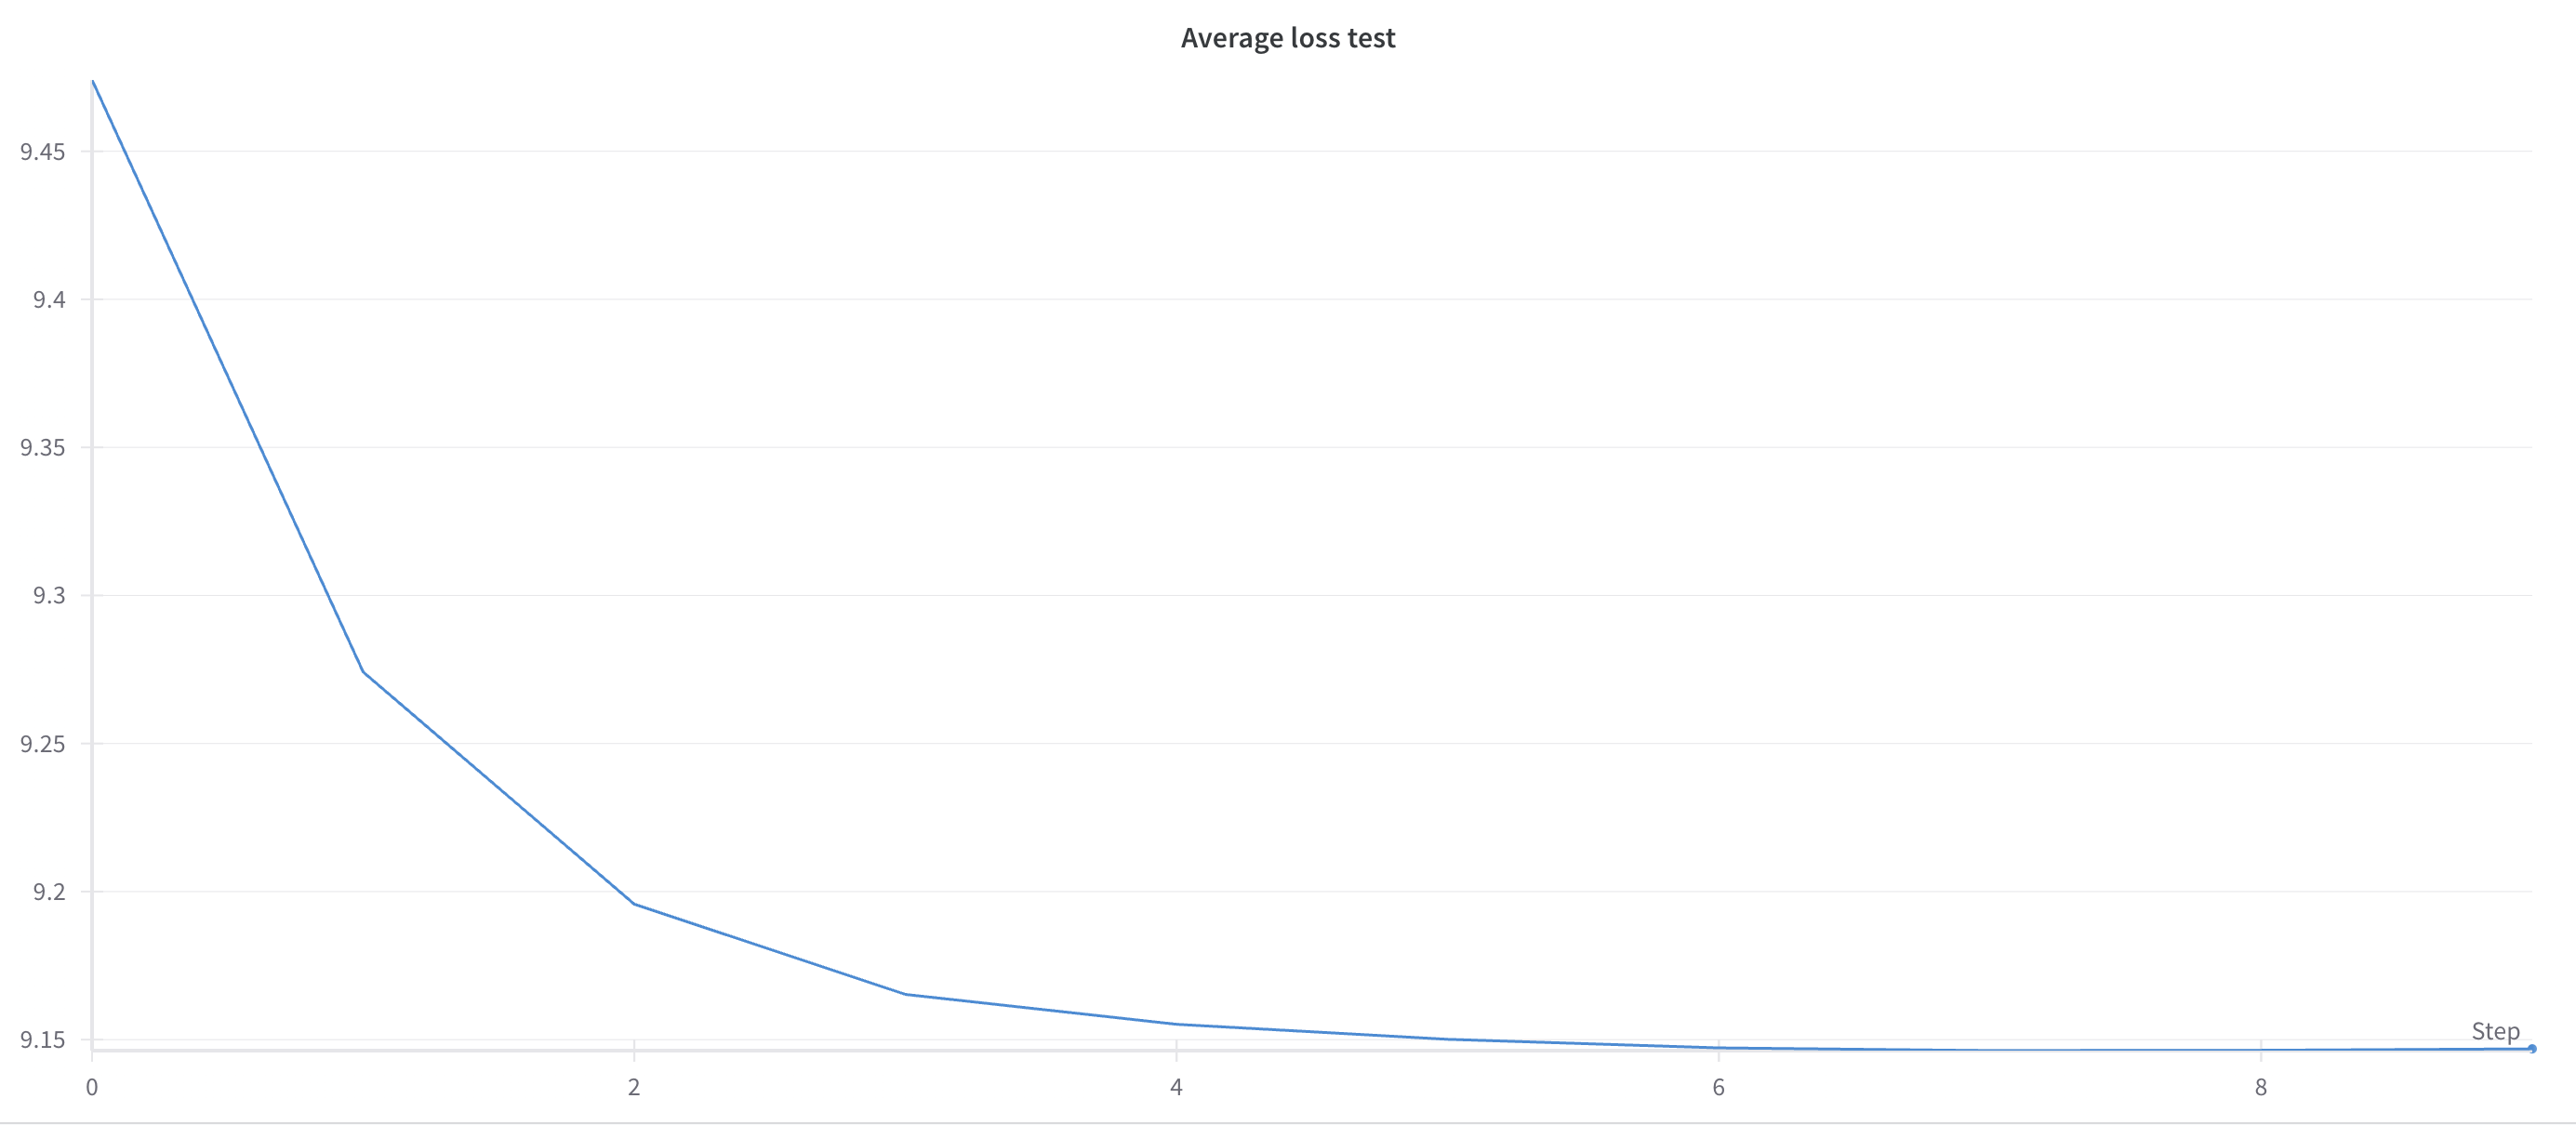

https://api.wandb.ai/links/maria-21-hse/k0gfm5vl

In [ ]:
class LinReg3(nn.Module):
    def __init__(self):
        super(LinReg3, self).__init__()
        self.linear1 = nn.Linear(90, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.linear2 = nn.Linear(128, 1)  # новый линейный слой

    def forward(self, x):
      x = self.relu(self.linear1(x))
      x = self.dropout(x)
      x = self.linear2(x)
      return x

In [ ]:
set_random_seed(42)
model_2 = LinReg3()
model_2.to(device)


optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001)
criterion_2 = nn.MSELoss()
# scheduler_3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_3, 'min') #https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
n_epochs = 10

train(model_2, optimizer_2, criterion_2, train_loader, test_loader, n_epochs)
test(model_2, criterion_2, test_loader)

Average loss test,█▇▆▆▅▄▃▂▂▁
Epoch,▁▂▃▃▄▅▆▆▇█
Average loss test,8.36499
Epoch,10


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 1/10, Average loss test: 8.3682


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 2/10, Average loss test: 8.2567


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 3/10, Average loss test: 8.2234


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 4/10, Average loss test: 8.2641


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 5/10, Average loss test: 8.2220


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 6/10, Average loss test: 8.2371


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 7/10, Average loss test: 8.2301


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 8/10, Average loss test: 8.3263


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 9/10, Average loss test: 8.2736


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 10/10, Average loss test: 8.3175


  0%|          | 0/404 [00:00<?, ?it/s]

tensor([1996.8253, 2005.0436, 2002.4131,  ..., 2001.8483, 2002.4547,
        2001.3273])

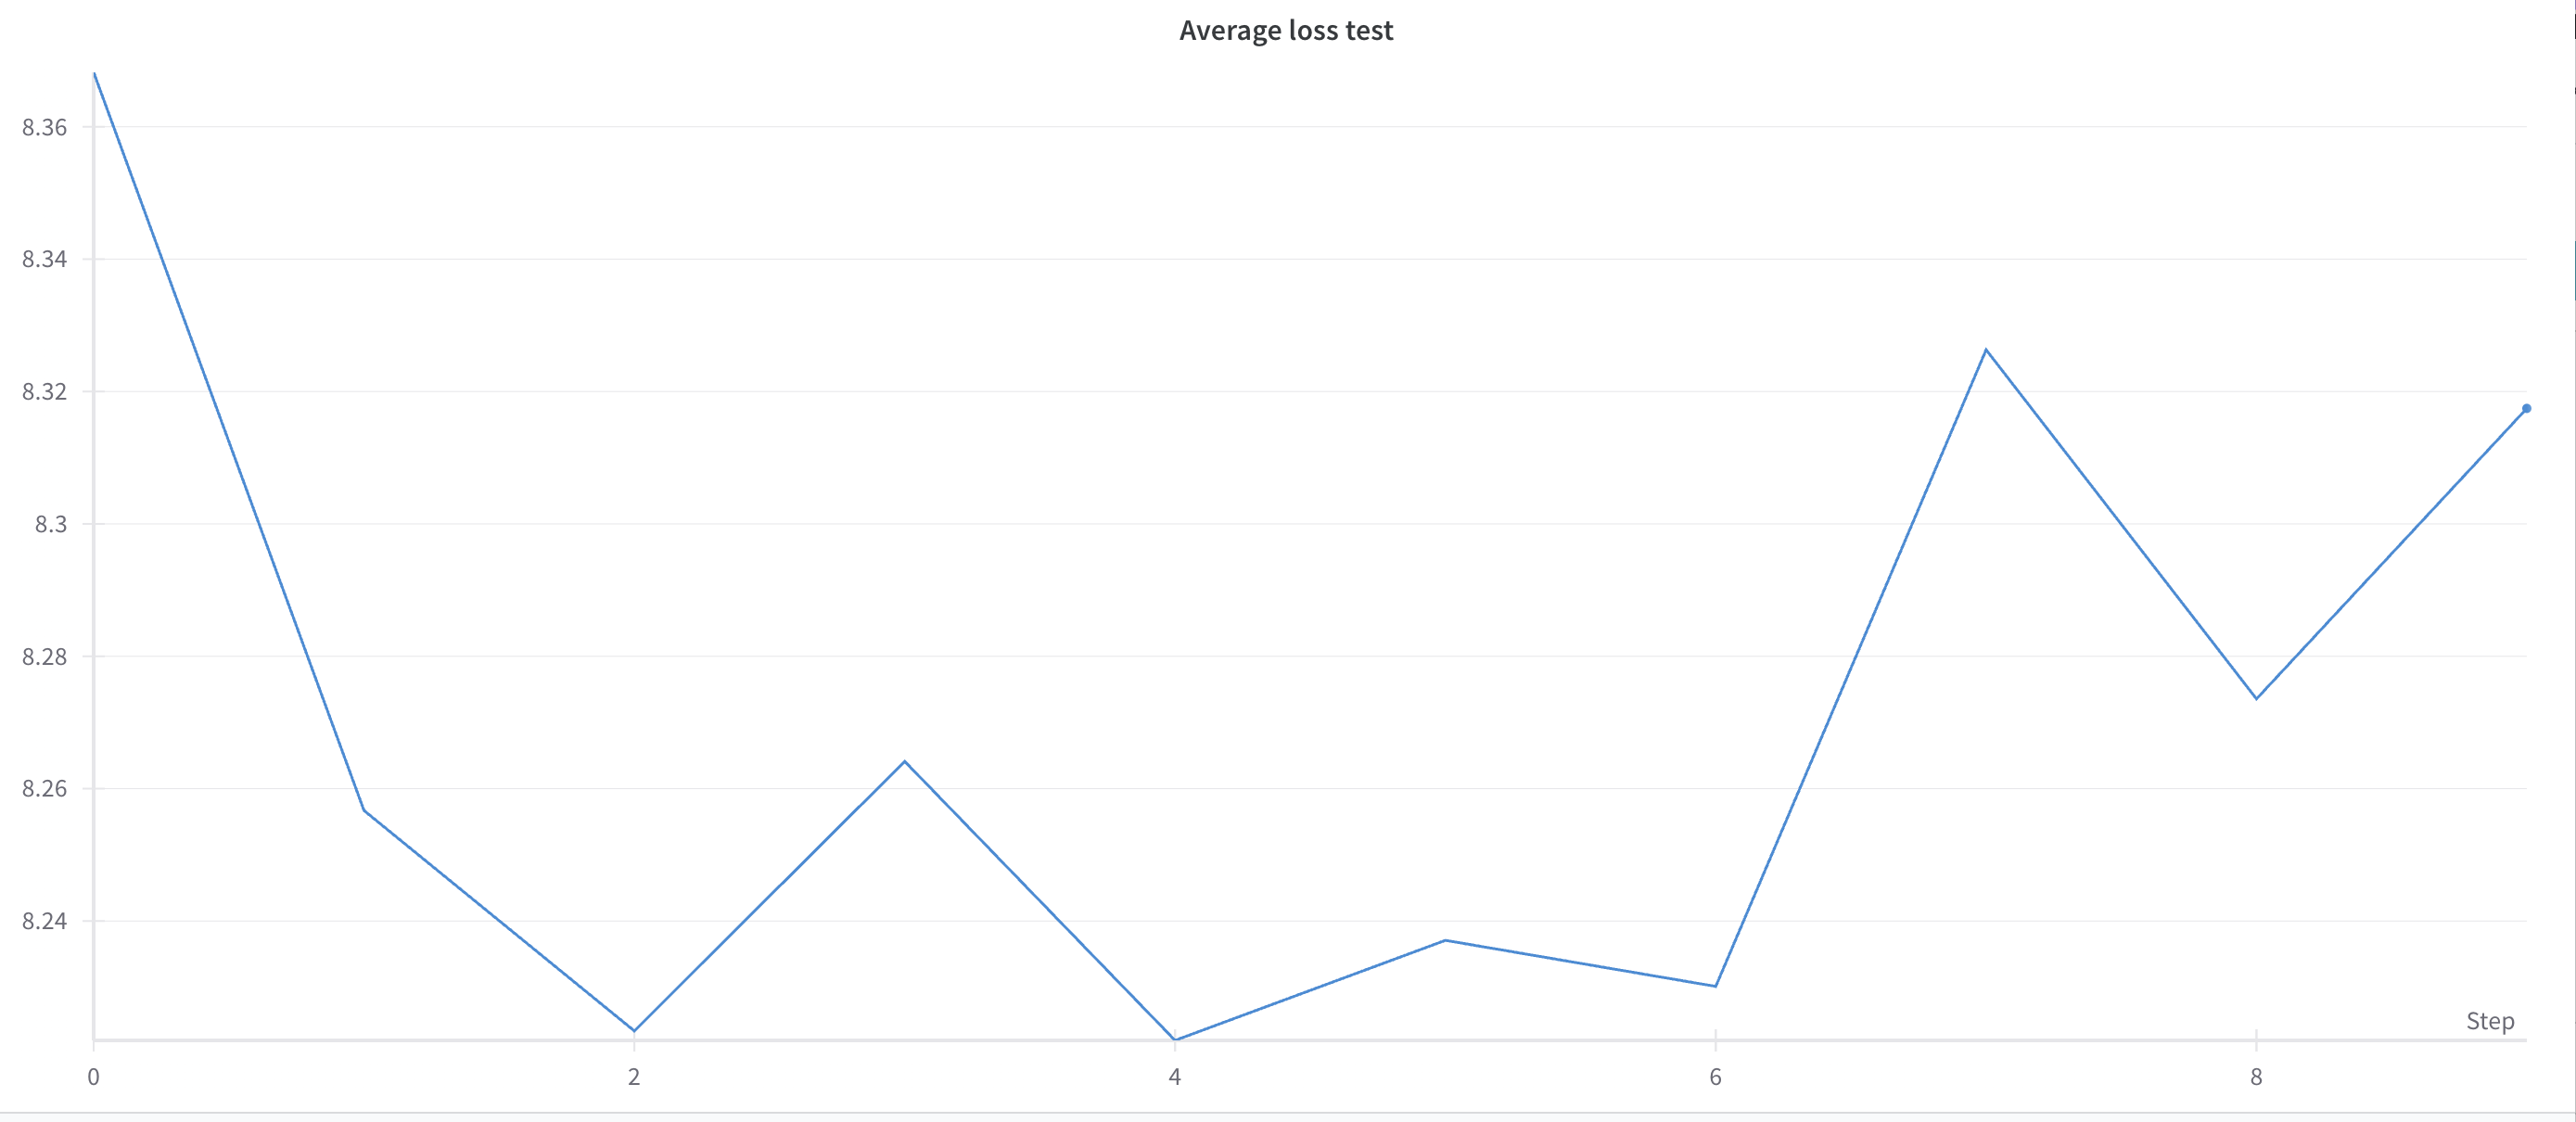

https://wandb.ai/maria-21-hse/hw1.2/reports/Average-loss-test-24-10-19-15-33-14---Vmlldzo5NzgyNDk1?accessToken=ojhxfjq9keroejpzbss3jct77iaa3cpny2dh7q7q09y0yl43z86ijbudli04n9d9

In [ ]:
def train(model, optimizer, criterion, scheduler, train_loader, test_loader, n_epochs):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        n_epochs - number of epochs (добавила чтобы менять кол-во эпох)
    """
    # очень много инсайтов взято из этой статьи про дропаут https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models/

    wandb.init(project="hw1.2")
    wandb.watch(model);



    model.train() # ставить модель в разные modes типа .train(), .eval() нужно для дропаута (и не только)

    for epoch in range(n_epochs):
      total_loss = 0
      for x_batch, y_batch in tqdm(train_loader):
          y_pred = model(x_batch.to(device))
          loss = torch.sqrt(criterion(y_pred,y_batch.view(-1,1).to(device))) #https://discuss.pytorch.org/t/rmse-loss-function/16540
          model.zero_grad()
          loss.backward()
          optimizer.step()



      model.eval()
      with torch.no_grad():
        for x_batch_test, y_batch_test in tqdm(test_loader):
            y_pred_test = model(x_batch_test.to(device))
            y_pred_nonorm = y_pred_test * std + mean # в чате ОГО подсказали, что если у меня сразу лосс падает до 0.8, то надо инверснуть таргет после нормировки, чтобы обратно в года превратить
            y_test_nonorm = y_batch_test * std + mean
            loss_test = torch.sqrt(criterion(y_pred_nonorm, y_test_nonorm.view(-1,1).to(device)))
            total_loss += loss_test.item()
            scheduler.step(loss_test)

      avg_loss_test = total_loss / len(test_loader)


      wandb.log({'Epoch': epoch + 1, 'Average loss test': avg_loss_test})
      print(f'Epoch {epoch + 1}/{n_epochs}, Average loss test: {avg_loss_test:.4f}')




def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """


    model.eval()
    predicts = torch.ones(len(test_loader.dataset)) # инициализация тензора с предсказаниями

    with torch.no_grad():
      for i, (x_batch, y_batch) in enumerate(tqdm(test_loader)): # с помощью enumerate получаем индекс каждого обрабатываемого батча https://discuss.pytorch.org/t/batch-size-and-validation-accuracy/4066
            y_pred = model(x_batch.to(device))  # прогноз на текущем батче
            y_pred_nonorm = y_pred * std + mean
            predicts[i * test_loader.batch_size : (i + 1) * test_loader.batch_size] = y_pred_nonorm.cpu().view(-1) # записываем предсказания для текущего батча в соответствующий сегмент тензора предиктс


    return predicts


In [ ]:
set_random_seed(42)
model_3 = LinReg3()
model_3.to(device)


optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.0001)
criterion_3 = nn.MSELoss()
scheduler_3 = torch.optim.lr_scheduler.StepLR(optimizer_3, step_size=5, gamma=0.1)
n_epochs = 20

train(model_3, optimizer_3, criterion_3, train_loader, test_loader, n_epochs)
test(model_3, criterion_3, test_loader)

Average loss test,█▅▅▄▄▃▄▃▂▃▃▂▂▂▂▁▁▂▂▁▁▁▂▂▁▁
Epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
Average loss test,8.26708
Epoch,26


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 1/20, Average loss test: 8.4754


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 2/20, Average loss test: 8.3899


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 3/20, Average loss test: 8.3644


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 4/20, Average loss test: 8.3576


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 5/20, Average loss test: 8.3332


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 6/20, Average loss test: 8.3256


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 7/20, Average loss test: 8.3375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 8/20, Average loss test: 8.3078


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 9/20, Average loss test: 8.2947


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 10/20, Average loss test: 8.3149


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 11/20, Average loss test: 8.3259


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 12/20, Average loss test: 8.2945


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 13/20, Average loss test: 8.2985


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 14/20, Average loss test: 8.2863


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 15/20, Average loss test: 8.2844


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 16/20, Average loss test: 8.2664


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 17/20, Average loss test: 8.2630


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 18/20, Average loss test: 8.2830


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 19/20, Average loss test: 8.2770


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 20/20, Average loss test: 8.2514


  0%|          | 0/404 [00:00<?, ?it/s]

tensor([1997.4148, 2003.4263, 2000.3312,  ..., 2001.7643, 1997.5500,
        2000.0377])

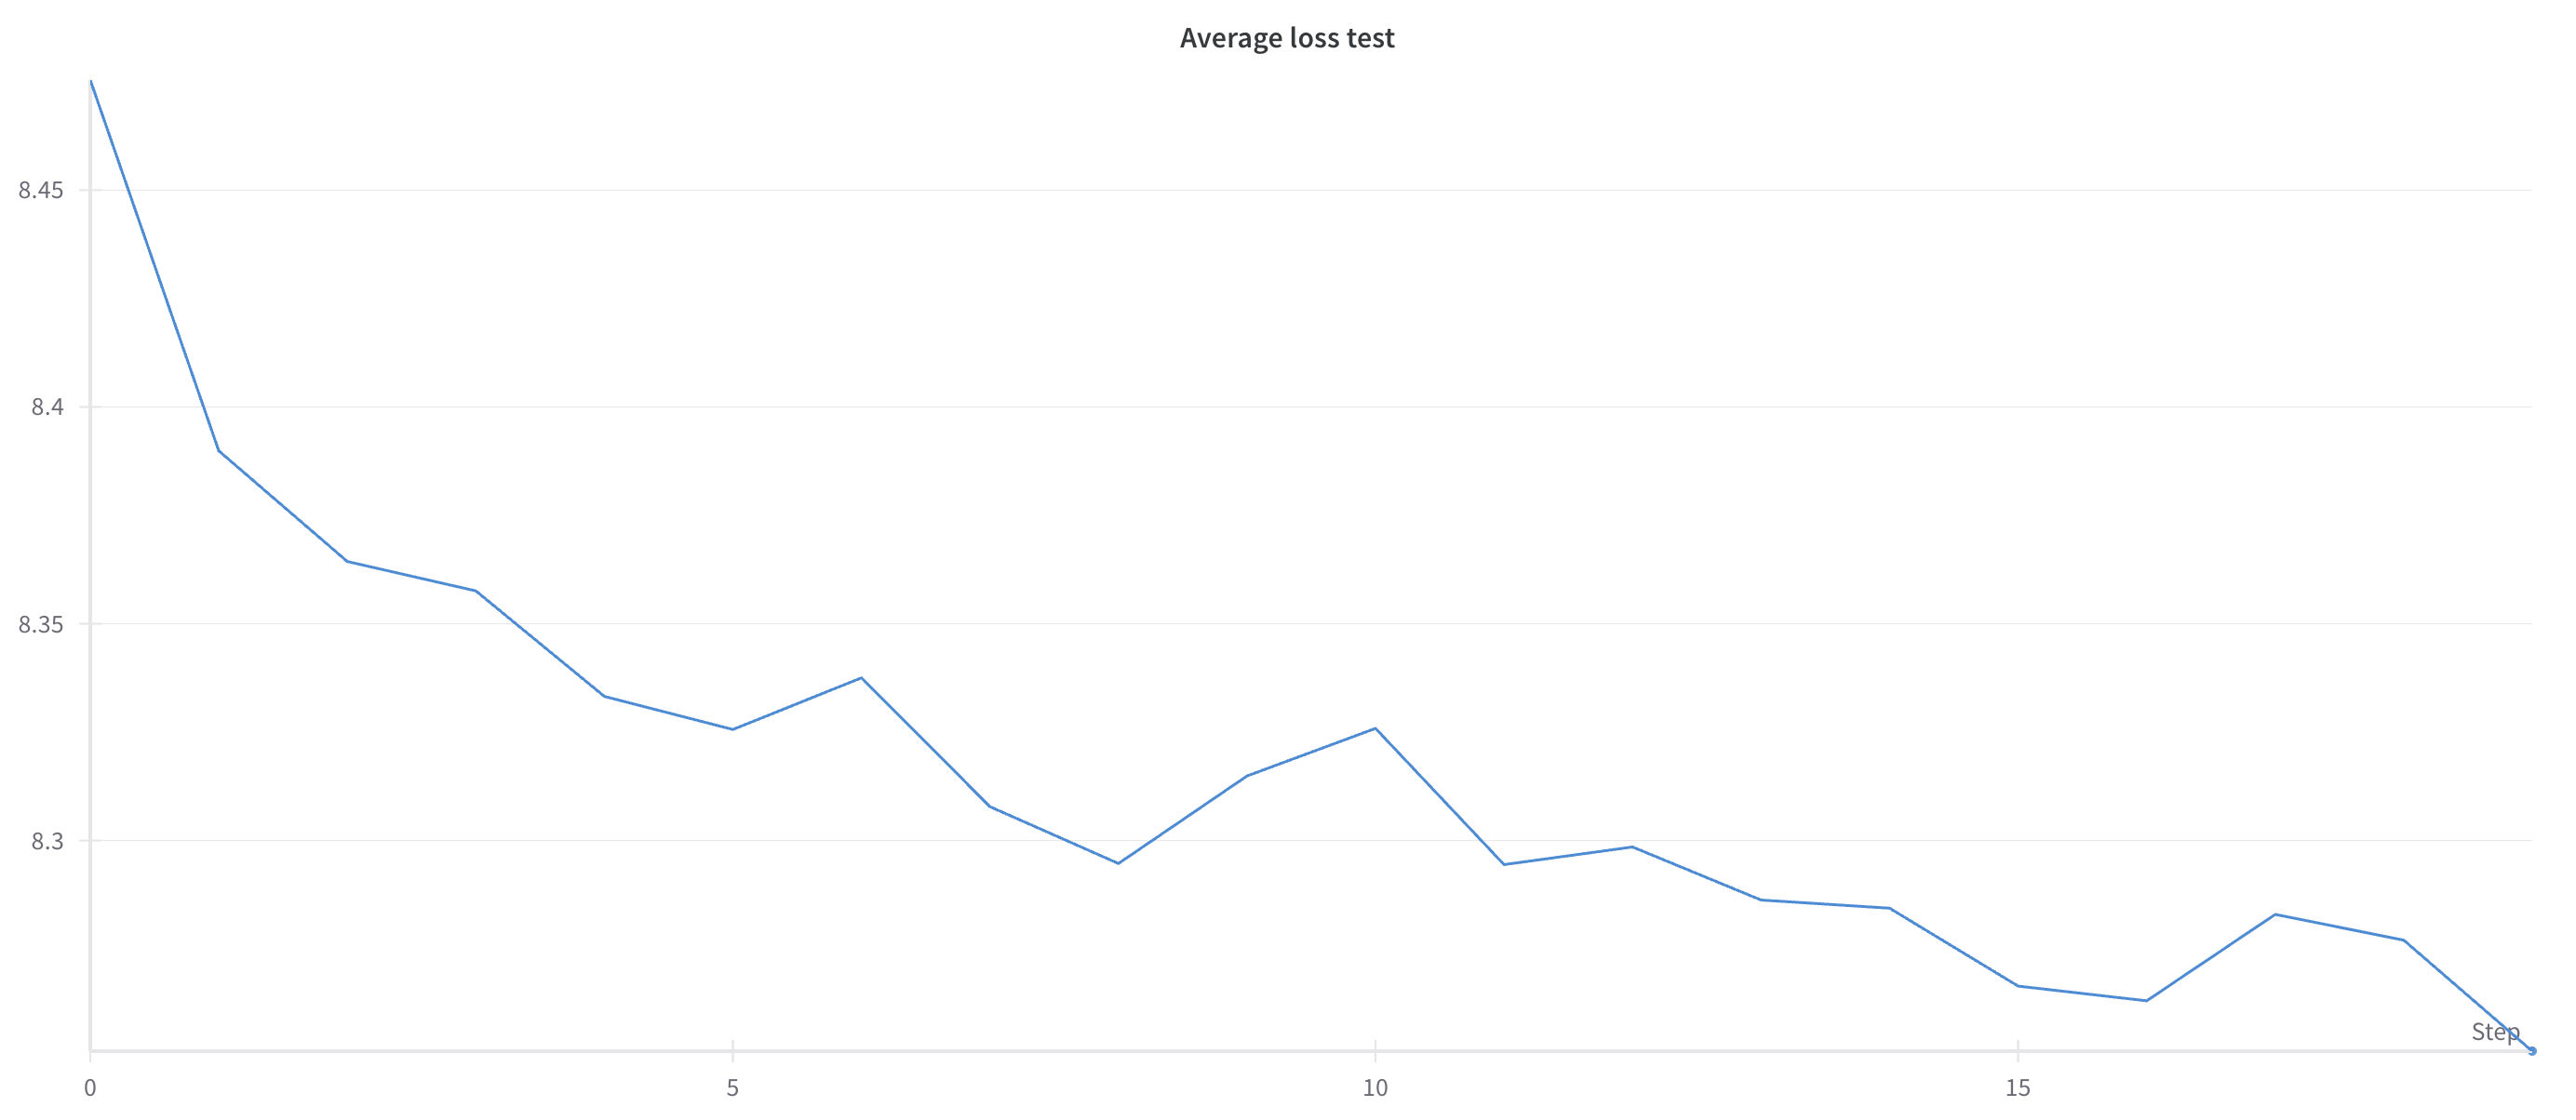

https://wandb.ai/maria-21-hse/hw1.2/reports/Average-loss-test-24-10-19-19-15-35---Vmlldzo5Nzg0NjI5?accessToken=7nazo0usm5gx5qmpxj70m3fz7zruepmvzs33b00ez4l50wqzp58g9iqlygsq0v8q

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

**Model 1:** для первой модельки я начала с базы и таких же баховых общепринятых гиперпараметров, чтобы посмотреть что и как будет работать. В классе LinReg2 у меня один слой, который сразу обрабатывает сразу все 90 in_features и выдает 1 на выходе. Также решила начать с базовой функции активации релу и сразу регуляризировала дропаутом, к слову, в статье, на которую я ориентировалась при имплементации дропаута, p (probability of an element to be zeroed) было равно 0.2 так что i just went with it, при этом когда пробовала менять до 0.3 и 0.5 ошибка увеличивалась, так что оставила как есть. Результаты в целом порадовали, но пока не наскребли на 4 балла с лоссом 9.1463


**Model 2:** На основе результатов прошлой модельки в этой я решила slightly усложнить архитектуру, чтобы у модельки была возможность выучить какие-то более сложные закономерности. Теперь у меня первый линейный слой, который выдает 128 нейронов, активация релу, дропаут, и второй линейный слой, который превращает 128 нейронов на входе в 1 на выходе. Как я и думала, это сразу помогло и ошибка упала, плюсом я добавила адам оптимизатор с такой же скоростью обучение, как и была на SGD до этого (lr = 0.001). Лосс сражу скатился в значения меньше 8.5, но это не единственное, где он скатился...и поднялся...а потом опять скатился...а потом опять...Получился какое-очень скачкообразный градиентный спуск



**Model 3:** Чтобы как-то улучшить ситуацию с амплитудой схождения, я увеличила число эпох и уменьшила скорость обучения до lr = 0.0001, при этом еще бахнула L2 регуляризацию scheduler, которая уменьшает скорость обучения на lr * 0.1 каждые пять эпох. И это помогло, теперь график выглядит более smooth и самый маленький лосс на последеней эпохе - 8.2514 🔥🔥🔥🔥

можно было бы дальше возиться, но мое ментальное здоровье tragically пострадало от этого задания + no time


## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

В прошлом задании уже выяснилось, что распределение классов таргета очень скошено влево, поэтому присутсвует проблемка с балансом классов 😞

In [ ]:
np.unique(y_train, return_counts = True)

(array([1922, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
        1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944,
        1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
        1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
        1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
        1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
        1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
        2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
        2011]),
 array([    6,     5,     7,    19,    40,    48,    79,    38,    31,
           11,     6,    28,    24,    22,    25,    19,    35,    14,
           31,    21,    13,    14,    27,    29,    55,    38,    53,
           58,    62,    65,   121,   108,   253,   535,   559,   522,
          544,   398,   521,   581,   867,   850,   996,  1202,  1517,
         1655,  1986,  2124,  1866,  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# моделька была написана с помощью первого семинара и вот этого имбового сайта https://www.learnpytorch.io/02_pytorch_classification/

class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.linear1 = nn.Linear(90, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 89)

    def forward(self, x):
      x = self.relu(self.linear1(x))
      x = self.linear2(x)
      return x

In [ ]:
from sklearn.preprocessing import LabelEncoder

ohe = LabelEncoder()
y_train_ohe = ohe.fit_transform(y_train)
y_test_ohe = ohe.fit_transform(y_test)

x_train_tensor = (torch.tensor(x_train.to_numpy(), dtype=torch.float).to(device))
y_train_tensor = torch.from_numpy(y_train_ohe).long()

x_test_tensor = (torch.tensor(x_test.to_numpy(), dtype=torch.float).to(device))
y_test_tensor = torch.from_numpy(y_test_ohe).long()

train_set = LinearDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_set, batch_size = 128, shuffle = True)

test_set = LinearDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_set, batch_size = 128, shuffle = False)

In [ ]:
set_random_seed(42)
model_4 = Classification()
model_4.to(device)
optimizer_4 = torch.optim.SGD(model_4.parameters(), lr=0.001)
criterion_4 = nn.CrossEntropyLoss()
n_epochs = 10

In [ ]:
def train_classification(model, optimizer, criterion, train_loader, test_loader, n_epochs):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        n_epochs - number of epochs (добавила чтобы менять кол-во эпох)
    """

    wandb.init(project="hw1.4")
    wandb.watch(model);



    model.train()

    for epoch in range(n_epochs):
      total_loss = 0
      for x_batch, y_batch in tqdm(train_loader):
          y_pred = model(x_batch.to(device))
          loss = criterion(y_pred,y_batch.to(device).long())
          model.zero_grad()
          loss.backward()
          optimizer.step()



      model.eval()
      with torch.no_grad():
         for x_batch_test, y_batch_test in tqdm(test_loader):
            y_pred_test = model(x_batch_test.to(device))
            loss_test = criterion(y_pred_test, y_batch_test.to(device))
            total_loss += loss_test.item()

      avg_loss_test = total_loss / len(test_loader)


      wandb.log({'Epoch': epoch + 1, 'Average loss test': avg_loss_test})
      print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {avg_loss_test:.4f}')


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_classification(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """

    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
      total_loss = 0
      for x_batch, y_batch in test_loader:
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch.long())
        total_loss += loss.item()

        classes = torch.argmax(y_pred, dim=1)
        predictions.extend(classes.tolist())
        labels.extend(y_batch.tolist())

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average = 'macro') # макро из-за дисбаланса классов
    recall = recall_score(labels, predictions, average = 'macro')
    f1 = f1_score(labels, predictions, average='macro')

    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

    return torch.tensor(predictions)

In [ ]:
assert test_classification(model_4, criterion_4, test_loader).shape[0] == y_test.shape[0]

Accuracy: 0.0130, Precision: 0.0078, Recall: 0.0082, F1-score: 0.0037


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
train_classification(model_4, optimizer_4, criterion_4, train_loader, test_loader, n_epochs)
test_classification(model_4, criterion_4, test_loader)

Average loss test,▁▅▅▆▆▆▆▇▇█
Epoch,▁▂▃▃▄▅▆▆▇█
Average loss test,1.88692
Epoch,10


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 1/10, Loss: 4.4931


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 2/10, Loss: 4.5534


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 3/10, Loss: 4.5455


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 4/10, Loss: 4.5189


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 5/10, Loss: 4.5012


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 6/10, Loss: 4.4878


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 7/10, Loss: 4.4806


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 8/10, Loss: 4.4782


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 9/10, Loss: 4.4758


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 10/10, Loss: 4.4788
Accuracy: 0.0010, Precision: 0.0024, Recall: 0.0002, F1-score: 0.0004


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


tensor([83, 84, 85,  ..., 81, 83, 84])

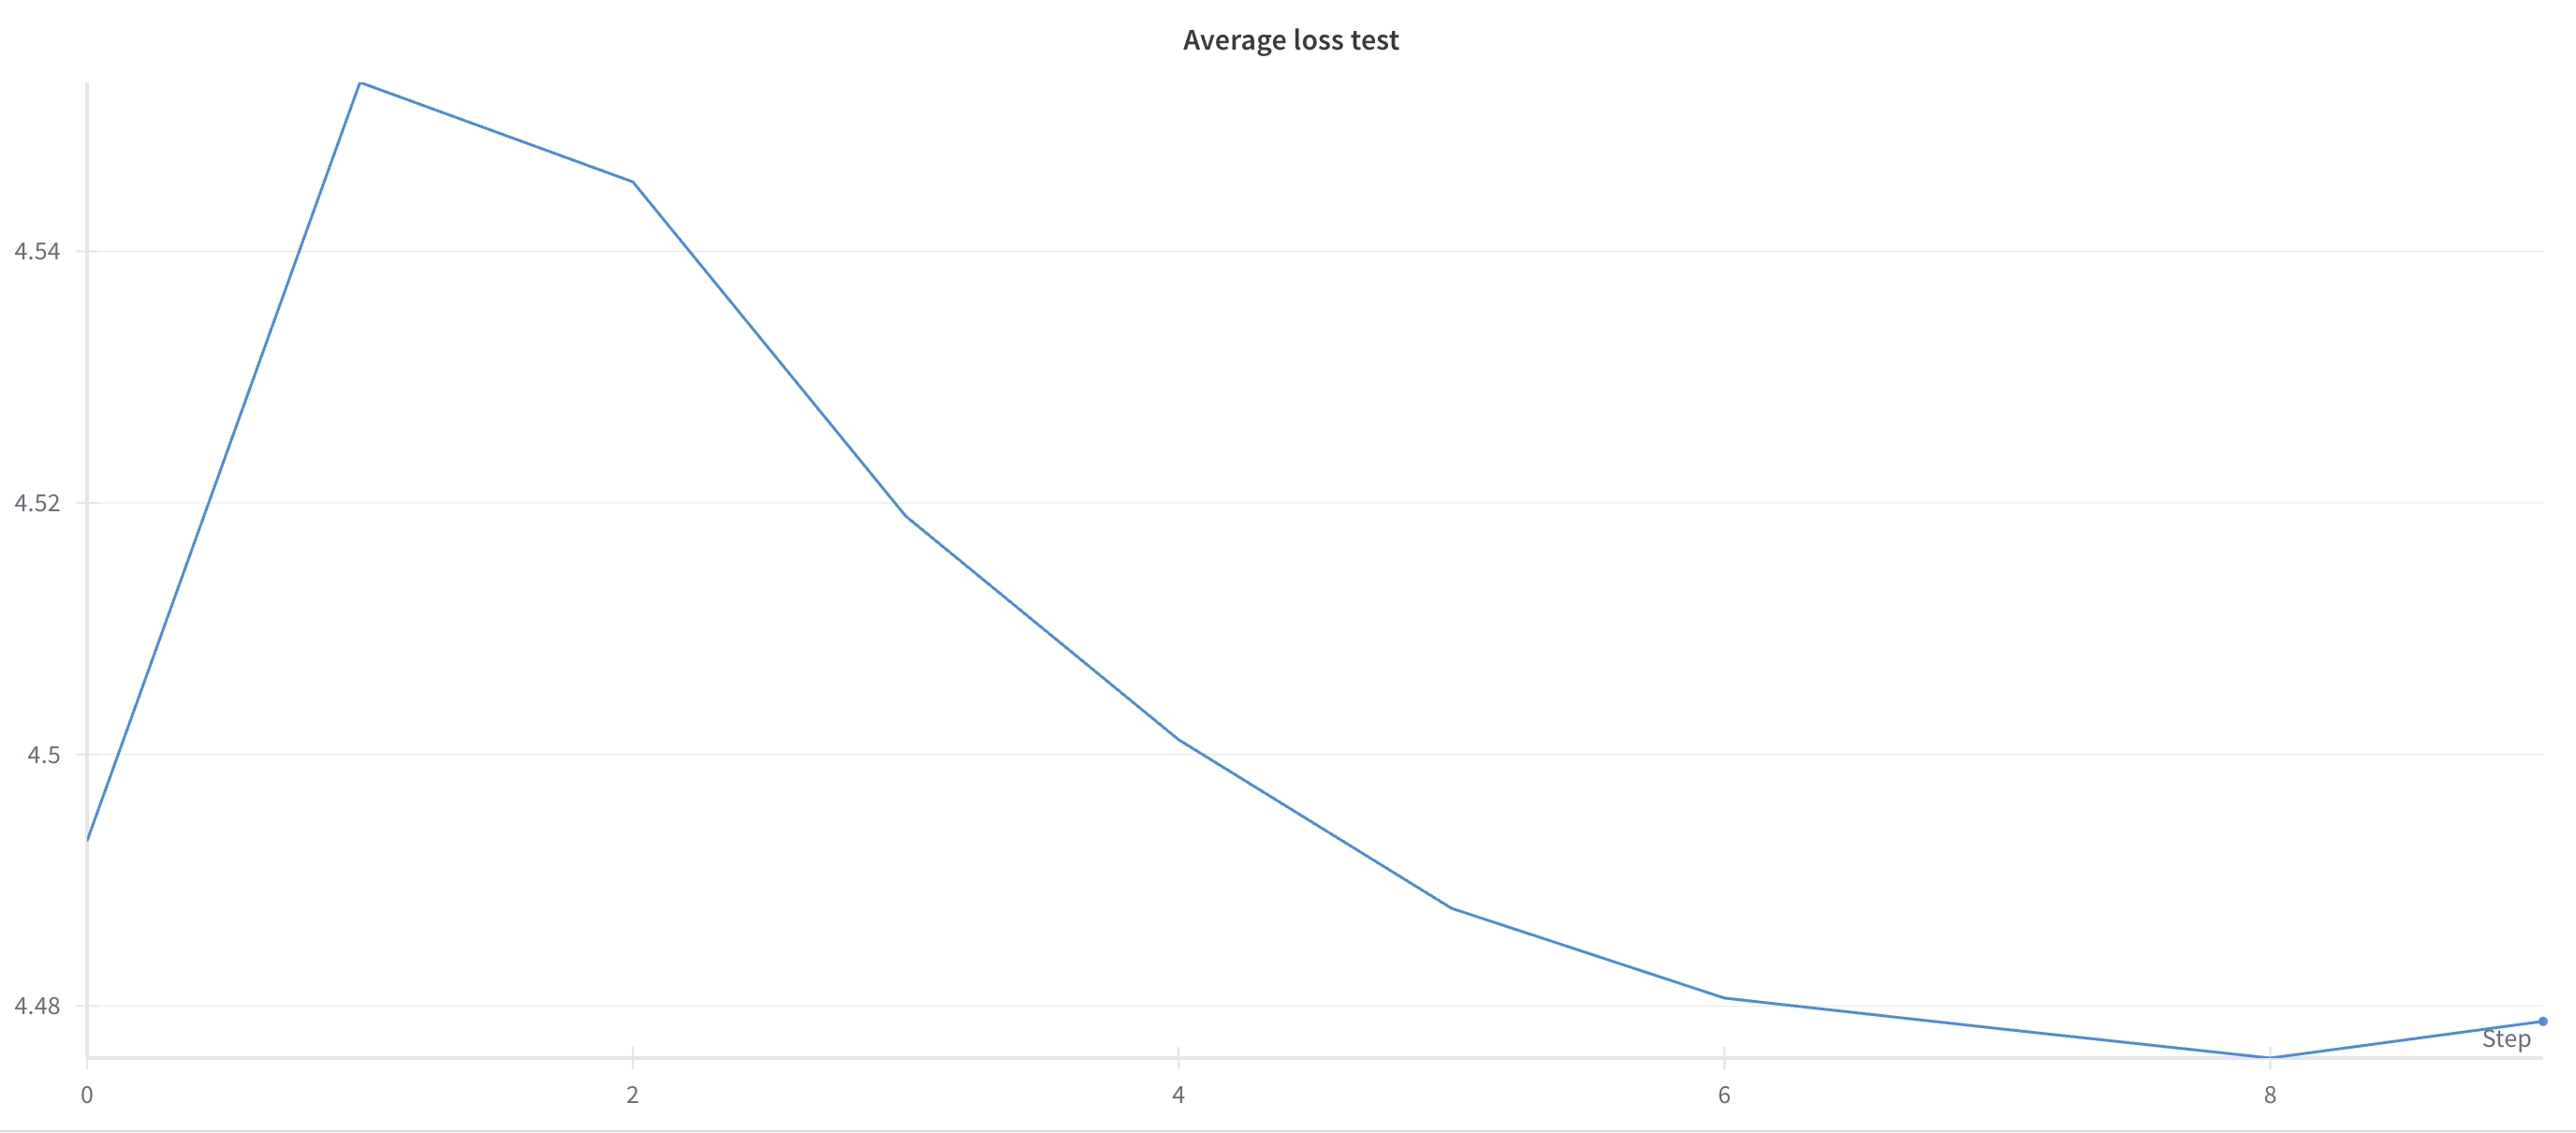

https://api.wandb.ai/links/maria-21-hse/2627vtxs

In [ ]:
class Classification2(nn.Module):
    def __init__(self):
        super(Classification2, self).__init__()
        self.linear1 = nn.Linear(90, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 10)

    def forward(self, x):
      x = self.relu(self.linear1(x))
      x = self.linear2(x)
      return x

In [ ]:
# Биннинг целевой переменной
num_bins = 10
y_train_binned = pd.cut(y_train, bins=num_bins, labels=False)
y_test_binned = pd.cut(y_test, bins=num_bins, labels=False)

ohe2 = LabelEncoder()
y_train_ohe2 = ohe2.fit_transform(y_train_binned)
y_test_ohe2 = ohe2.fit_transform(y_train_binned)

x_train_tensor = (torch.tensor(x_train.to_numpy(), dtype=torch.float).to(device))
y_train_tensor = torch.from_numpy(y_train_ohe2).long()

x_test_tensor = (torch.tensor(x_test.to_numpy(), dtype=torch.float).to(device))
y_test_tensor = torch.from_numpy(y_test_ohe2).long()

train_set = LinearDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_set, batch_size = 128, shuffle = True)

test_set = LinearDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_set, batch_size = 128, shuffle = False)

In [ ]:
set_random_seed(42)
model_5 = Classification2()
model_5.to(device)
optimizer_5 = torch.optim.SGD(model_5.parameters(), lr=0.0001)
criterion_5 = nn.CrossEntropyLoss()
n_epochs = 10

In [ ]:
train_classification(model_5, optimizer_5, criterion_5, train_loader, test_loader, n_epochs)
test_classification(model_5, criterion_5, test_loader)

Average loss test,▃█▇▅▃▂▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Average loss test,4.47877
Epoch,10


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.8998


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.7120


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.6118


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.5529


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.5166


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.4930


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.4770


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.4657


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.4574


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.4512


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.4514, Precision: 0.0772, Recall: 0.1000, F1-score: 0.0729


tensor([9, 9, 9,  ..., 9, 9, 9])

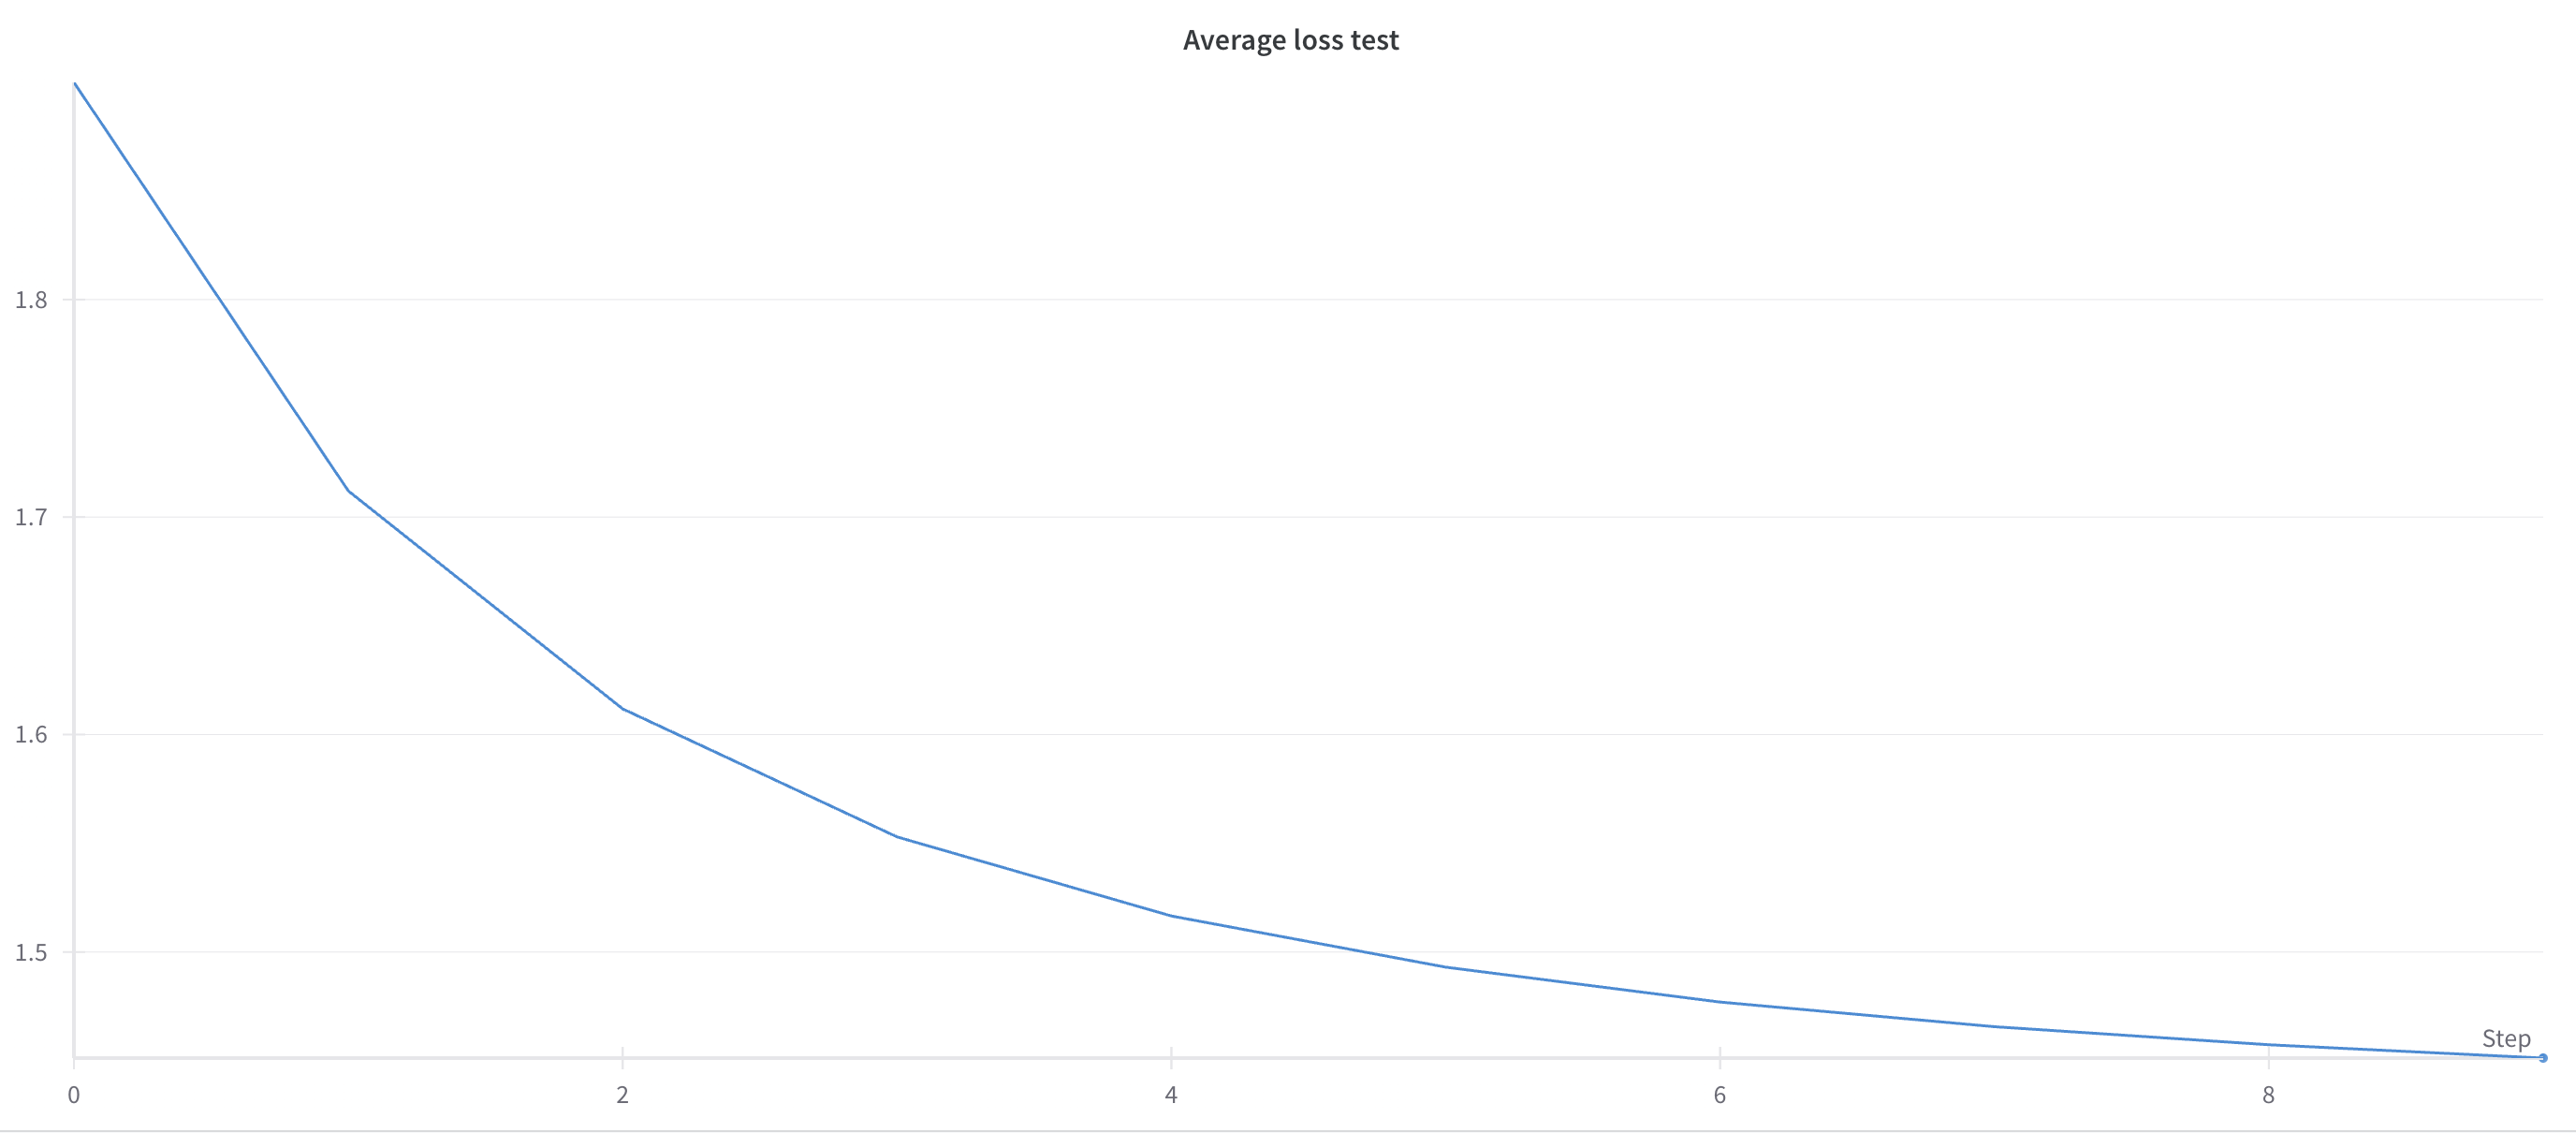

https://wandb.ai/maria-21-hse/hw1.4/reports/Average-loss-test-24-10-20-20-11-31---Vmlldzo5Nzk2MTY2 -- это самый идеальный график за эту работу

ЧТОЖ сейчас 19:36 20 октября я делала это на протяжении всей недели и всего этого дня и вот мы здесь..
В последнем задании очень долго не могла избавиться от ошибок, поэтому остановилаьсь на самом простом варианте модели с двумя слоями и релу --> результаты неутешительные.

С другой стороны, чем проще модель, тем легче оценить разницу между классификацией по всем классам и классификацией по 10 бинам. Из-за скачкообразного графика лосса первой модели уменьшила скорость обучения второй и спуск стал более мягким. Сами бины заметно улучшили ситуацию с лоссом и с accuracy, но все таки recall и percision оставляют желать лучшего (они буквально еле отличимы от нуля), поэтому неьзя сделать вывод о сильном улучшении качества. Уверенна, что это из-за дисбаланса классов, но не очень понимаю, почему года после 2000 все равно плохо предсказываются, если их там большое количесвто(( Ну и также из-за того, что мы решиаем задачу регрессии через задачу классификации...Все таки классификациями сложно с непрерывными значениями и они переобучаются на кокретные классы, в отличие от регрессии, что здесь более целесообразна.
